<a href="https://colab.research.google.com/github/M-Sparsh-Mehra/Astro-ML/blob/main/Astro_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prep

In [ ]:
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [ ]:
from astroquery.simbad import Simbad
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import os

# --- SIMBAD Setup ---
custom_simbad = Simbad()
custom_simbad.TIMEOUT = 60
custom_simbad.ROW_LIMIT = 1
#custom_simbad.add_votable_fields('coordinates')
custom_simbad.add_votable_fields('ra(d)', 'dec(d)')


# --- Query SIMBAD for M67 (NGC 2682) ---
result_table = custom_simbad.query_object("NGC 2682")

# Enforce capitalized column names (default already uses uppercase)
#assert 'RA' in result_table.colnames and 'DEC' in result_table.colnames, "RA/DEC not found in uppercase"
#assert 'RA_d' in result_table.colnames and 'DEC_d' in result_table.colnames, "RA/DEC not found in table"
assert 'ra' in result_table.colnames and 'dec' in result_table.colnames, "RA/DEC not found in table"


#ra = result_table['RA_d'][0]
#dec = result_table['DEC_d'][0]

ra = result_table['ra'][0]
dec = result_table['dec'][0]
# --- Convert coordinates to decimal degrees ---
#coord = SkyCoord(result_table['RA'][0], result_table['DEC'][0], unit=(u.hourangle, u.deg))
#ra = coord.ra.degree
#dec = coord.dec.degree
radius = 1.0  # degrees

output_name = "M67_within_1deg"

# --- Set Gaia table to use ---
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

# --- ADQL query ---
query = f"""
SELECT source_id, ra, dec, pmra, pmra_error,parallax,
       pmdec, pmdec_error, phot_g_mean_mag,
       phot_bp_mean_mag, phot_rp_mean_mag, pmra_pmdec_corr,
       bp_rp, phot_bp_rp_excess_factor
FROM gaiadr3.gaia_source
WHERE 1 = CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra}, {dec}, {radius})
)
AND ruwe < 1.4
AND astrometric_gof_al < 3.0
AND astrometric_excess_noise_sig <= 2.0
AND visibility_periods_used >= 10
"""

print(f"Coordinates of M67 from SIMBAD: RA = {ra:.6f}, Dec = {dec:.6f}")
print("Running Gaia query...")

# --- Make sure output directory exists ---
os.makedirs("data", exist_ok=True)

# --- Run the query and download results ---
Gaia.launch_job_async(query, dump_to_file=True, output_format='csv', output_file=f"data/{output_name}.csv")
Gaia.launch_job_async(query, dump_to_file=True, output_format='votable', output_file=f"data/{output_name}.vot.gz")

/tmp/ipython-input-2-997164182.py:12: DeprecationWarning: 'ra(d)' has been renamed 'ra'. You'll see it appearing with its new name in the output table
  custom_simbad.add_votable_fields('ra(d)', 'dec(d)')
/tmp/ipython-input-2-997164182.py:12: DeprecationWarning: 'dec(d)' has been renamed 'dec'. You'll see it appearing with its new name in the output table
  custom_simbad.add_votable_fields('ra(d)', 'dec(d)')


Coordinates of M67 from SIMBAD: RA = 132.846000, Dec = 11.814000
Running Gaia query...


/usr/local/lib/python3.11/dist-packages/astroquery/utils/tap/taputils.py:294: UserWarning: The output format selected is not compatible with compression. data/M67_within_1deg.vot.gz will be renamed to data/M67_within_1deg.vot
  warnings.warn(f'The output format selected is not compatible with compression. {output_file}'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as mp
import seaborn as sns
from sklearn.model_selection import train_test_split

#DATA

In [ ]:
df = pd.read_csv("data/M67_within_1deg.csv")

Added parallex to the dataset.

In [ ]:
df

,source_id,ra,dec,pmra,pmra_error,parallax,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra_pmdec_corr,bp_rp,phot_bp_rp_excess_factor
0,598663847733780864,132.884619,10.909714,0.442408,0.469513,-0.122700,-3.264539,0.331133,20.031670,20.409060,19.641174,-0.158149,0.767885,1.115417
1,598665153403811584,133.014416,10.959910,4.593960,0.279966,1.250371,0.298346,0.228379,19.100042,20.187150,18.055244,-0.411542,2.131905,1.368328
2,598619931693029504,133.281301,10.918383,0.057432,0.296746,0.334538,-0.612217,0.199424,19.082134,19.941385,18.253416,-0.179246,1.687969,1.231701
3,598642613415506816,132.703519,10.841912,-1.324554,0.320395,0.498585,-9.762845,0.235957,19.215780,19.970497,18.415120,-0.230845,1.555378,1.241881
4,598613540781594752,133.128546,10.853843,-3.797075,0.025858,0.654920,-4.019322,0.020611,14.731710,15.105234,14.188128,-0.373933,0.917107,1.208571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14140,607990248958012672,132.286291,12.234218,-5.845476,0.587859,0.338400,-3.210716,0.452480,20.020117,21.302576,18.859425,-0.186745,2.443151,1.448573
14141,607990248958101760,132.283761,12.228874,3.468348,1.089595,-1.269681,-12.402405,0.801261,20.628384,21.100273,20.016136,-0.085146,1.084137,1.209378
14142,607990283317791232,132.259641,12.237231,1.553191,0.343464,0.307591,-4.156176,0.235105,19.274897,19.698689,18.710281,-0.012345,0.988407,1.198895
14143,607990313381861376,132.273676,12.246604,-1.931631,0.746084,0.734975,1.440591,0.536345,20.155000,20.788425,19.085829,-0.089410,1.702597,1.531556


#EDA

In [ ]:
df.describe()

,source_id,ra,dec,pmra,pmra_error,parallax,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra_pmdec_corr,bp_rp,phot_bp_rp_excess_factor
count,1.414500e+04,14145.000000,14145.000000,14145.000000,14145.000000,14145.000000,14145.000000,14145.000000,14141.000000,14059.000000,14065.000000,14145.000000,14059.000000,14059.000000
mean,6.033758e+17,132.822882,11.808610,-3.960972,0.426107,0.862197,-4.756097,0.301019,18.396704,19.068229,17.578949,-0.232832,1.489642,1.333581
std,3.151993e+15,0.490750,0.483418,9.009928,0.488261,1.107644,9.316834,0.340853,1.915869,2.034225,1.809921,0.130968,0.611354,0.367797
min,5.986135e+17,131.824610,10.815150,-229.438302,0.013177,-6.109591,-263.453166,0.009825,10.845772,11.387247,10.152047,-0.929029,-0.524195,0.860977
25%,5.989545e+17,132.443840,11.434439,-8.032916,0.091878,0.309942,-6.372968,0.066558,17.202950,17.794230,16.438568,-0.306614,0.930808,1.210406
50%,6.048929e+17,132.817839,11.807795,-2.731637,0.253539,0.741145,-2.973487,0.182771,18.871550,19.700985,17.990408,-0.233009,1.444010,1.281548
75%,6.049983e+17,133.197328,12.178166,0.012031,0.561989,1.200916,-0.662147,0.401108,19.962906,20.741647,19.038120,-0.158356,1.994033,1.403583
max,6.081443e+17,133.863793,12.813004,146.285817,3.261755,22.044759,66.073392,2.649074,20.977900,22.760517,21.074638,0.679720,3.428502,37.231915


phot_bp_mean_mag  | 330–680 nm
phot_rp_mean_mag  |	630–1050 nm
phot_g_mean_mag	  | 330–1050 nm

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14145 entries, 0 to 14144
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   source_id                 14145 non-null  int64  
 1   ra                        14145 non-null  float64
 2   dec                       14145 non-null  float64
 3   pmra                      14145 non-null  float64
 4   pmra_error                14145 non-null  float64
 5   parallax                  14145 non-null  float64
 6   pmdec                     14145 non-null  float64
 7   pmdec_error               14145 non-null  float64
 8   phot_g_mean_mag           14141 non-null  float64
 9   phot_bp_mean_mag          14059 non-null  float64
 10  phot_rp_mean_mag          14065 non-null  float64
 11  pmra_pmdec_corr           14145 non-null  float64
 12  bp_rp                     14059 non-null  float64
 13  phot_bp_rp_excess_factor  14059 non-null  float64
dtypes: flo

In [ ]:
df.columns

Index(['source_id', 'ra', 'dec', 'pmra', 'pmra_error', 'parallax', 'pmdec',
       'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'pmra_pmdec_corr', 'bp_rp',
       'phot_bp_rp_excess_factor'],
      dtype='object')

In [ ]:
features = ['ra', 'dec', 'pmra', 'pmdec', 'bp_rp','parallax']
df = df.dropna(subset=features)

In [ ]:
ra_center = df['ra'].median()
dec_center = df['dec'].median()
df['ra_rel'] = df['ra'] - ra_center
df['dec_rel'] = df['dec'] - dec_center

/tmp/ipython-input-10-941236101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ra_rel'] = df['ra'] - ra_center
/tmp/ipython-input-10-941236101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dec_rel'] = df['dec'] - dec_center


In [ ]:
x = df[['ra_rel', 'dec_rel', 'pmra', 'pmdec', 'bp_rp','parallax']].values

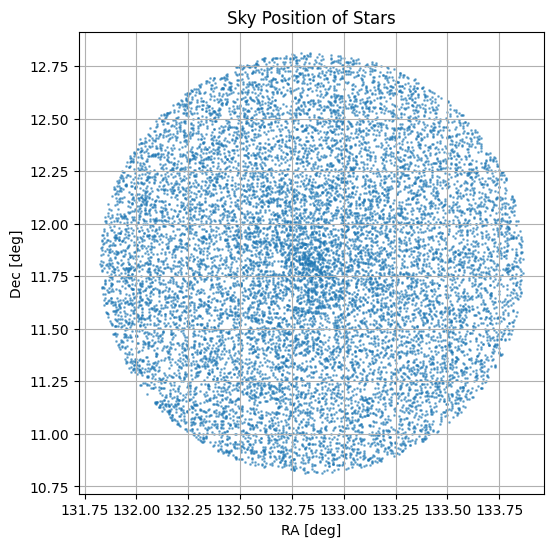

In [ ]:
mp.figure(figsize=(6,6))
mp.scatter(df['ra'], df['dec'], s=1, alpha=0.5)
mp.xlabel("RA [deg]")
mp.ylabel("Dec [deg]")
mp.title("Sky Position of Stars")
mp.grid()

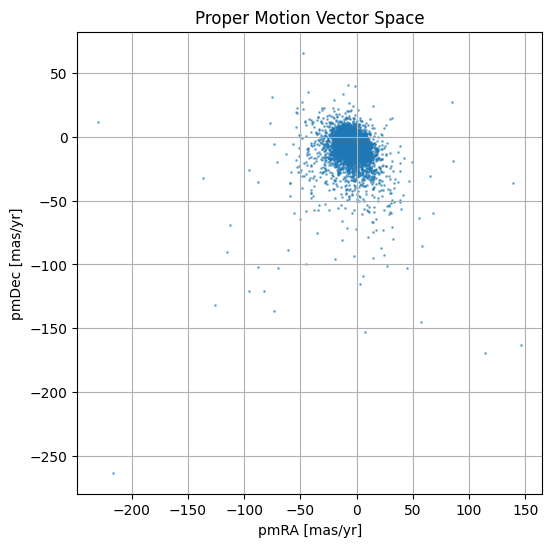

In [ ]:
mp.figure(figsize=(6,6))
mp.scatter(df['pmra'], df['pmdec'], s=1, alpha=0.5)
mp.xlabel("pmRA [mas/yr]")
mp.ylabel("pmDec [mas/yr]")
mp.title("Proper Motion Vector Space")
mp.grid()

Cluster members = tight clump in proper motion space. Field stars = more spread out.

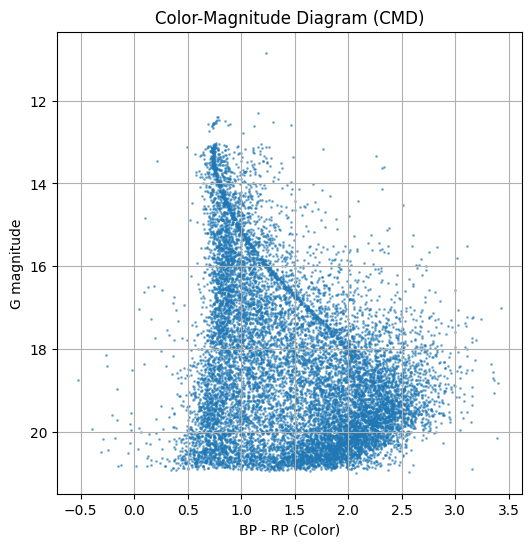

In [ ]:
mp.figure(figsize=(6,6))
mp.scatter(df['bp_rp'], df['phot_g_mean_mag'], s=1, alpha=0.5)
mp.gca().invert_yaxis()  # because magnitude is reverse
mp.xlabel("BP - RP (Color)")
mp.ylabel("G magnitude")
mp.title("Color-Magnitude Diagram (CMD)")
mp.grid(True)

## Correlation Heatmap


<Axes: >

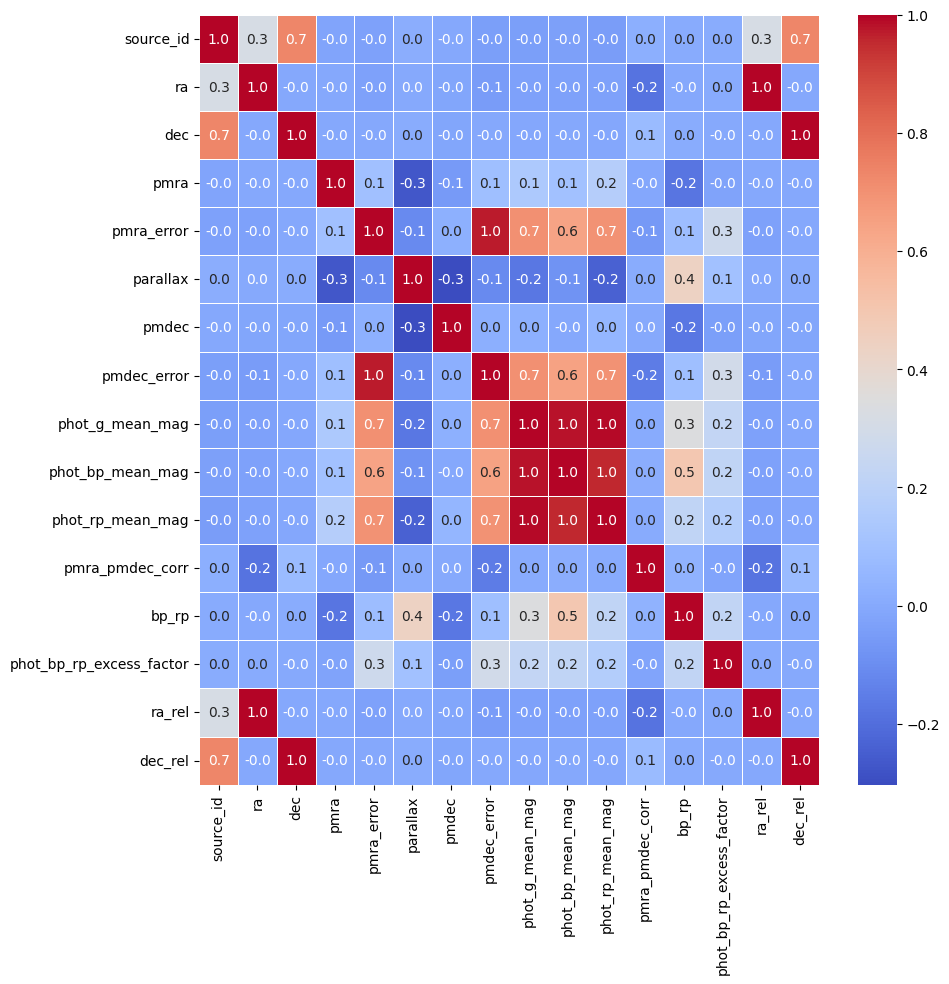

In [ ]:
mp.figure(figsize=(10,10))
sns.heatmap(df.corr(),fmt=".1f", annot=True, cmap='coolwarm',linewidth=.5)

In [ ]:
scaler = StandardScaler()
df_scaled= scaler.fit_transform(df)

In [ ]:
print(df_scaled)

[[-1.49605383  0.12569391 -1.85915108 ... -0.59318454  0.12569391
  -1.85915108]
 [-1.49563954  0.39021727 -1.75536725 ...  0.09447711  0.39021727
  -1.75536725]
 [-1.5099885   0.93412068 -1.84122732 ... -0.27700828  0.93412068
  -1.84122732]
 ...
 [ 1.4632467  -1.14799678  0.88556398 ... -0.36620797 -1.14799678
   0.88556398]
 [ 1.46325624 -1.11939381  0.90494311 ...  0.53829276 -1.11939381
   0.90494311]
 [ 1.4632576  -1.13754561  0.90024209 ...  0.11732069 -1.13754561
   0.90024209]]


In [ ]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

#DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(df_scaled)

In [ ]:
df_scaled['cluster'] = labels

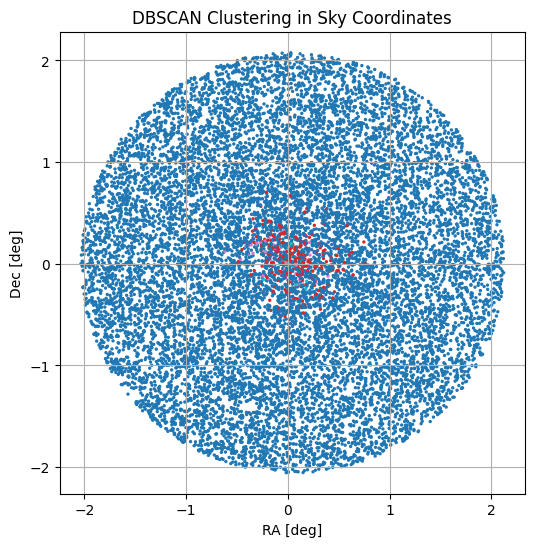

In [ ]:
mp.figure(figsize=(6,6))
mp.scatter(df_scaled['ra'], df_scaled['dec'], c=df_scaled['cluster'], cmap='tab10', s=2)
mp.xlabel("RA [deg]")
mp.ylabel("Dec [deg]")
mp.title("DBSCAN Clustering in Sky Coordinates")
mp.grid()
mp.show()

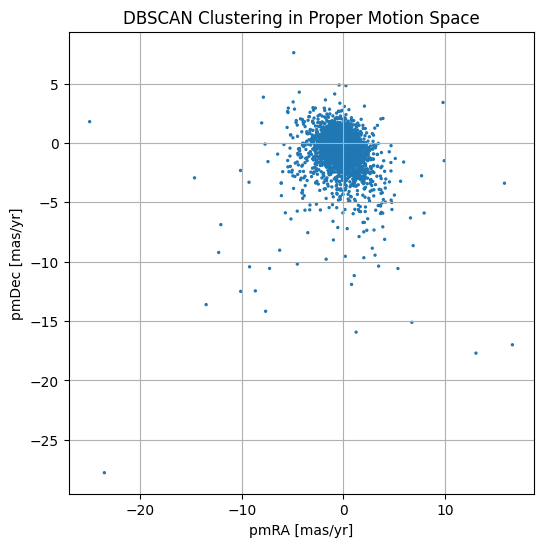

In [ ]:
mp.figure(figsize=(6,6))
mp.scatter(df_scaled['pmra'], df_scaled['pmdec'], c=df_scaled['cluster'], cmap='tab10', s=2)
mp.xlabel("pmRA [mas/yr]")
mp.ylabel("pmDec [mas/yr]")
mp.title("DBSCAN Clustering in Proper Motion Space")
mp.grid()
mp.show()

#KNN

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(df_scaled)
labelsknn = kmeans.labels_

In [ ]:
df_scaled['cluster'] = labelsknn

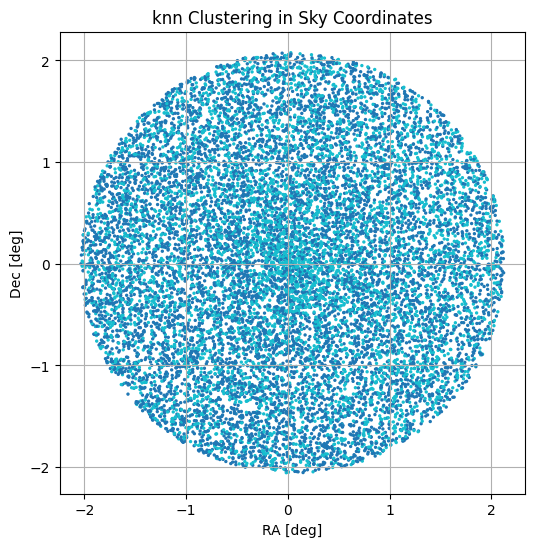

In [ ]:
mp.figure(figsize=(6,6))
mp.scatter(df_scaled['ra'], df_scaled['dec'], c=df_scaled['cluster'], cmap='tab10', s=2)
mp.xlabel("RA [deg]")
mp.ylabel("Dec [deg]")
mp.title("knn Clustering in Sky Coordinates")
mp.grid()
mp.show()

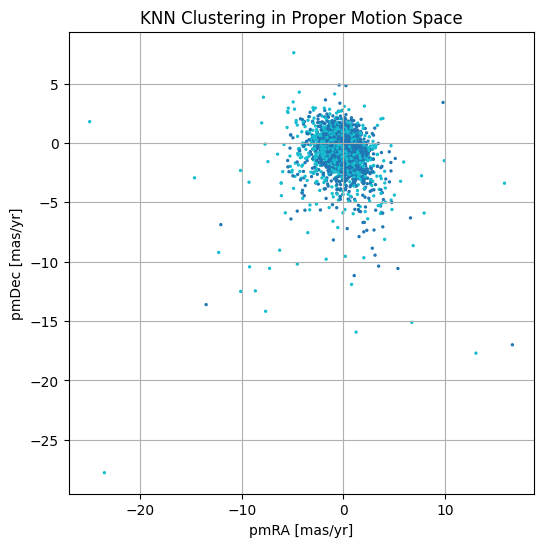

In [ ]:
mp.figure(figsize=(6,6))
mp.scatter(df_scaled['pmra'], df_scaled['pmdec'], c=df_scaled['cluster'], cmap='tab10', s=2)
mp.xlabel("pmRA [mas/yr]")
mp.ylabel("pmDec [mas/yr]")
mp.title("KNN Clustering in Proper Motion Space")
mp.grid()
mp.show()

# pyUPMASK


In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix

# Optional for KDE evaluation grid
from scipy.stats import gaussian_kde

preprocessing


In [ ]:
def preprocess_features(df):
    features = ['pmra', 'pmdec', 'parallax', 'bp_rp', 'phot_g_mean_mag']
    positional = ['ra', 'dec']
    df = df.dropna(subset=features + positional).reset_index(drop=True)

    # Scale non-positional features
    X_nonpos = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_nonpos)

    return df, X_scaled

k means clustering


In [ ]:
def cluster_data(X_scaled, n_clusters=30):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    return labels

In [ ]:
def ripley_k(points, r_max, n_r=20):
    N = len(points)                                #points: array of [RA, Dec] positions
    dists = distance_matrix(points, points)        # pairwise distances
    r_vals = np.linspace(0, r_max, n_r)            #r_max: maximum radius to test (in degrees)
                                                   #n_r: number of radius bins

    K_vals = []

    for r in r_vals:
        count = np.sum((dists < r) & (dists > 0))   # Count how many other points are within radius r

        K = count / N
        K_vals.append(K)

    return r_vals, K_vals    #For each radius r, counts the number of neighbors within r.
    #Builds up a curve K(r) across n_r radius values



#to test whether a set of sky coordinates is spatially uniform.
def is_cluster_uniform(ra_dec, r_max=0.1):
    r_vals, K_vals = ripley_k(ra_dec, r_max)
    # Compare against a uniform expectation (flat K function)
    K_mean = np.mean(K_vals)
    return K_mean < 1  # if true → reject :True if the distribution is uniform
    # low k low density


#apply RFR to all clusters

def apply_rfr(df, labels):
    keep = np.full(len(df), False)
    for cluster in np.unique(labels):
        idx = np.where(labels == cluster)[0]

        # Ignore small clusters (noisy)
        if len(idx) < 5:
            continue
        coords = df.loc[idx, ['ra', 'dec']].values

        if not is_cluster_uniform(coords):          # If it's not uniform (it's clustered), keep it
            keep[idx] = True
    return keep

# separate real cluster stars from residual field contamination
def fit_gumm(df):
    coords = df[['ra', 'dec']].values
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    gmm.fit(coords)                                #Trains the GMM on the positional data (RA, Dec).
    probs = gmm.predict_proba(coords)
    cluster_idx = np.argmax(gmm.means_[:, 0])  # assume cluster is higher density
    return probs[:, cluster_idx]

#this fn assigns a probability to each star for being a cluster member.
def compute_kde_probabilities(df):
    coords = df[['ra', 'dec']].values.T
    kde = gaussian_kde(coords)
    probs = kde(coords)
    return probs / np.max(probs)

In [ ]:
def pyupmask_pipeline(df, n_clusters=30):
    df, X_scaled = preprocess_features(df)
    labels = cluster_data(X_scaled, n_clusters=n_clusters)
    df['initial_label'] = labels

    keep = apply_rfr(df, labels)
    df_kept = df[keep].reset_index(drop=True)

    # Gaussian + Uniform mixture model
    df_kept['gumm_prob'] = fit_gumm(df_kept)

    # KDE for final smoothed probability
    df_kept['kde_prob'] = compute_kde_probabilities(df_kept)

    return df_kept

## RUNNING THE PIPELINE


In [ ]:
df_kept = pyupmask_pipeline(df, n_clusters=30)

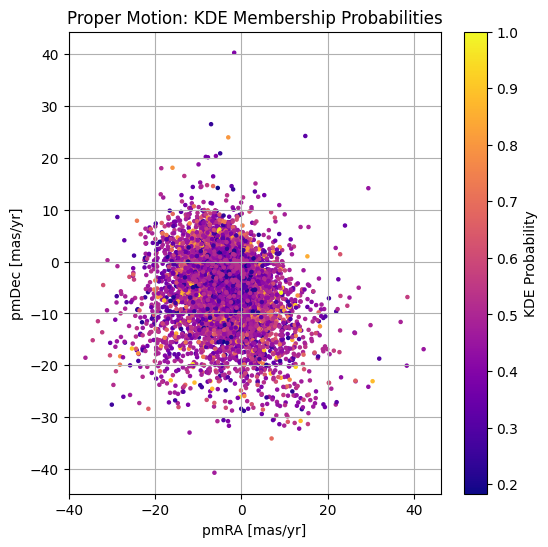

In [ ]:
mp.figure(figsize=(6,6))
mp.scatter(df_kept['pmra'], df_kept['pmdec'], c=df_kept['kde_prob'], cmap='plasma', s=5)
mp.xlabel("pmRA [mas/yr]")
mp.ylabel("pmDec [mas/yr]")
mp.title("Proper Motion: KDE Membership Probabilities")
mp.colorbar(label='KDE Probability')
mp.grid(True)

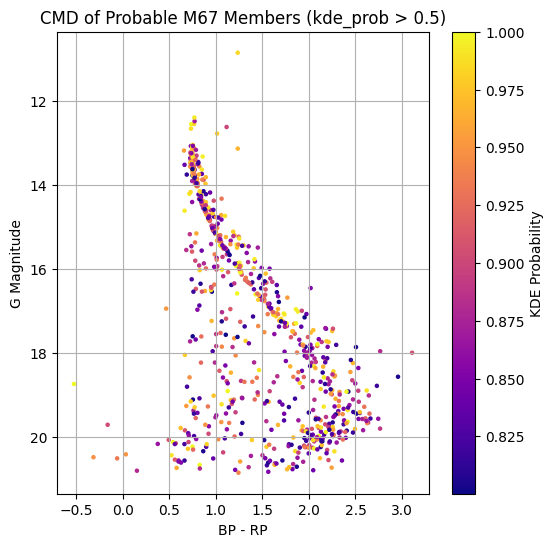

In [ ]:
mp.figure(figsize=(6,6))
members = df_kept[df_kept['kde_prob'] > 0.8]
mp.scatter(members['bp_rp'], members['phot_g_mean_mag'], c=members['kde_prob'], cmap='plasma', s=5)
mp.gca().invert_yaxis()
mp.xlabel("BP - RP")
mp.ylabel("G Magnitude")
mp.title("CMD of Probable M67 Members (kde_prob > 0.5)")
mp.colorbar(label='KDE Probability')
mp.grid(True)
